In [1]:
import sys
path_to_scripts = '../scripts'
sys.path.append(path_to_scripts)
import os
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import json
import argparse
from colorama import Fore, Style, init
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoModel, AutoTokenizer

root_dir = "/Users/peetz/Documents/GitHub/LLM_Thesis"
data_dir = Path(root_dir, "data")

NYT = Path(data_dir, "pre-processed data", "NYT","combined_dataset.json")


/Users/peetz/miniconda3/envs/LLM_Thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
df = pd.read_json(NYT, orient="records", lines=True)

In [3]:
vertexSet = []
relations = []

for index, row in tqdm(df.iterrows(), total=df.shape[0], desc='Processing data'):
    for ver in row['vertexSet']:
        for v in ver:
            vertexSet.append(v['type'])
    for rel in row['labels']:
        relations.append(rel['r'])

from collections import Counter
# Counting the occurrences of each relation and entity type
relation_counts = Counter(relations)
entity_counts = Counter(vertexSet)

# Creating DataFrames for plotting
relation_df = pd.DataFrame(relation_counts.items(), columns=['Relation', 'Count'])
entity_df = pd.DataFrame(entity_counts.items(), columns=['Entity', 'Count'])


Processing data: 100%|██████████| 66196/66196 [00:00<00:00, 75511.47it/s]


**Plotting the number of entties and relations present in the dataset**

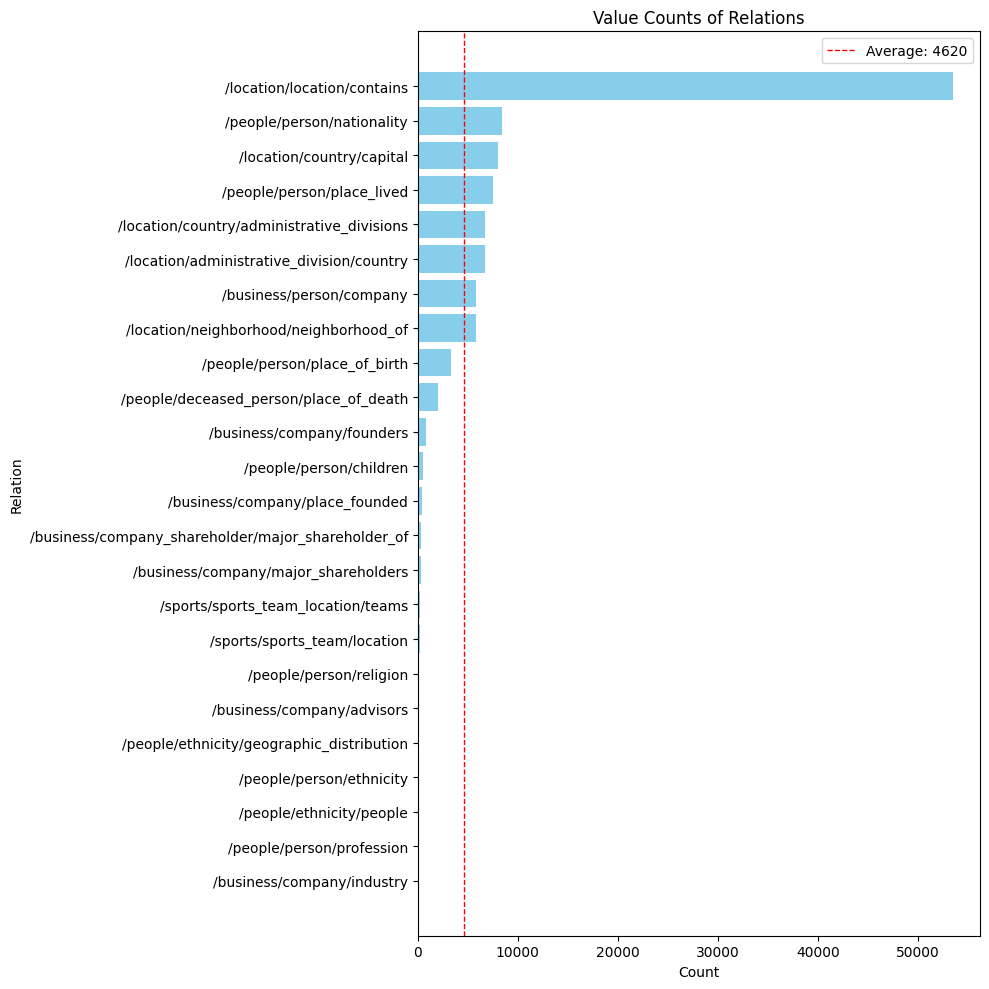

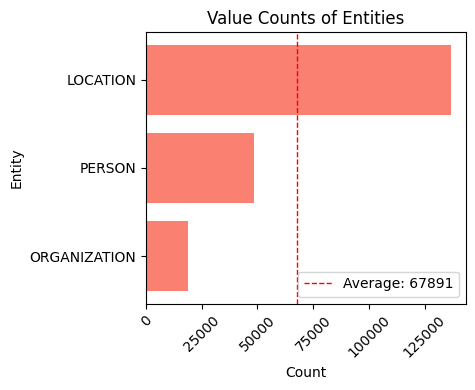

In [4]:
# Plotting the value counts of relations horizontally
relation_df = relation_df.sort_values(by='Count', ascending=True)
average_relation_count = relation_df['Count'].mean()

plt.figure(figsize=(10, 10))
plt.barh(relation_df['Relation'], relation_df['Count'], color='skyblue')
plt.axvline(average_relation_count, color='red', linestyle='--', linewidth=1, label=f'Average: {average_relation_count:.0f}')
plt.xlabel('Count')
plt.ylabel('Relation')
plt.title('Value Counts of Relations')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting the value counts of entities
entity_df = entity_df.sort_values(by='Count', ascending=True)
average_entity_count = entity_df['Count'].mean()

plt.figure(figsize=(5, 4))
plt.barh(entity_df['Entity'], entity_df['Count'], color='salmon')
plt.axvline(average_entity_count, color='red', linestyle='--', linewidth=1, label=f'Average: {average_entity_count:.0f}')
plt.xlabel('Count')
plt.ylabel('Entity')
plt.title('Value Counts of Entities')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Inspection of Entities

In [5]:
# Extract all unique relations
relations = set(rel['r'] for labels in df['labels'] for rel in labels)

# Generate samples for all relations
samples = {}
for relation in relations:
    relation_rows = df[df.apply(lambda row: any(rel['r'] == relation for rel in row['labels']), axis=1)]
    samples[relation] = relation_rows.head(2)

# Display samples
for relation, sample in samples.items():
    print(f"Samples for relation: {relation}")
    for idx, row in sample.iterrows():
        print("Sents:", row['sents'])
        print("VertexSet:", row['vertexSet'])
        print("Labels:", row['labels'])
        print()
    print("\n")

Samples for relation: /people/person/profession
Sents: [['INSIDE', 'THE', 'N.B.A.', 'Correction', ':', 'February', '9', ',', '2006', ',', 'Thursday', 'A', 'sports', 'article', 'on', 'the', 'Spotlight', 'page', 'on', 'Sunday', 'about', 'Dick', 'Bavetta', ',', 'a', 'longtime', 'referee', 'in', 'the', 'National', 'Basketball', 'Association', ',', 'misstated', 'the', 'number', 'he', 'was', 'approaching', 'to', 'set', 'the', 'record', 'for', 'regular-season', 'games', 'worked', '.']]
VertexSet: [[{'name': 'Dick Bavetta', 'pos': [21, 23], 'type': 'PERSON', 'sent_id': 0}], [{'name': 'National Basketball Association', 'pos': [29, 32], 'type': 'ORGANIZATION', 'sent_id': 0}]]
Labels: [{'h': 0, 't': 1, 'r': '/people/person/profession', 'evidence': [0]}]

Sents: [['A', 'sports', 'article', 'on', 'the', 'Spotlight', 'page', 'on', 'Sunday', 'about', 'Dick', 'Bavetta', ',', 'a', 'longtime', 'referee', 'in', 'the', 'National', 'Basketball', 'Association', ',', 'misstated', 'the', 'number', 'he', 'was'

#### Walkthrough of the types

1. People/Person/Profession: This type refers to persons specific profession and should remain as it is -- Could be named Profession
2. People/Person/Place_of_Birth: i.e Place of Birth of a person
3. /people/person/nationality: Nationality - Nationality of a person. 
4. /location/neighborhood/neighborhood_of: Neighborhood
5. /location/country/administrative_divisions: Could be mapped to contains as it is refering to example Canada contain Ontario. 
6. /sports/sports_team_location/teams Location of sports teams. Could be mapped to located in. 
7. /people/ethnicity/geographic_distribution -- Ethnicity location (russians are located in russia) or russians in Ukraine. 
8. /business/company/founders Could be named 'founder of'
9. /people/person/children -- Directional Linda mother (0) mother of joseph(1). 
10. /location/country/capital -- Capital of Paris is capital of france. [0,1]
11. /business/company/major_shareholders -- Shareholder of
12. /business/company_shareholder/major_shareholder_of -- Shareholder of
13. /sports/sports_team/location: Location of sports teams. Could be mapped to located in. 
14. /location/administrative_division/country: Could be mapped to contains. Same as '5'.
15. /location/location/contains: Located in -- Annadele is the located of bard college. 
16. /business/company/industry: Industry. 
17. /people/person/ethnicity Leonard is Lakota. -- Ethnicity. 
18. /people/person/place_lived: place-lived 
19. /people/ethnicity/people: lokata enthincy of Leonard. 
20. /people/deceased_person/place_of_death: Place of death
21. /business/person/company: Works for
22. /people/person/religion: Abu Izzadeen, Islam, religion. 
23. /business/company/place_founded: Founded in., busch founded in St. louis. 
24. /business/company/advisors, gneral to be associated with a company. CEO etc. Cluld be works for. 

/business/company/founders	Founder of
/people/person/children	Children
/business/company/place_founded	Founded in
/people/ethnicity/people	Ethnicity
/people/person/ethnicity	Ethnicity of
/people/person/religion	Religion
/business/company_shareholder/major_shareholder_of	Shareholder of
/people/person/profession	Profession
/location/country/administrative_divisions	Located in
/people/person/nationality	Nationality
/business/company/advisors	Works for
/location/neighborhood/neighborhood_of	Neighborhood
/business/company/major_shareholders	Shareholder of
/people/deceased_person/place_of_death	Place of Death
/location/location/contains	Contains location
/people/ethnicity/geographic_distribution	Located in
/business/company/industry	Industry
/people/person/place_lived	Place lived
/location/country/capital	Capital 
/sports/sports_team_location/teams	Located in
/location/administrative_division/country	Located in
/business/person/company	Works for
/sports/sports_team/location	Located in
/people/person/place_of_birth	Place of Birth


Now lets clean the data using the runner.py

In [6]:
NYT = Path(data_dir, "pre-processed data", "NYT","combined_dataset_corrected.json")

In [7]:
df = pd.read_json(NYT, orient="records", lines=False)

In [8]:
vertexSet = []
relations = []

for index, row in tqdm(df.iterrows(), total=df.shape[0], desc='Processing data'):
    for ver in row['vertexSet']:
        for v in ver:
            vertexSet.append(v['type'])
    for rel in row['labels']:
        relations.append(rel['r'])

from collections import Counter
# Counting the occurrences of each relation and entity type
relation_counts = Counter(relations)
entity_counts = Counter(vertexSet)

# Creating DataFrames for plotting
relation_df = pd.DataFrame(relation_counts.items(), columns=['Relation', 'Count'])
entity_df = pd.DataFrame(entity_counts.items(), columns=['Entity', 'Count'])


Processing data: 100%|██████████| 66196/66196 [00:00<00:00, 76005.84it/s]


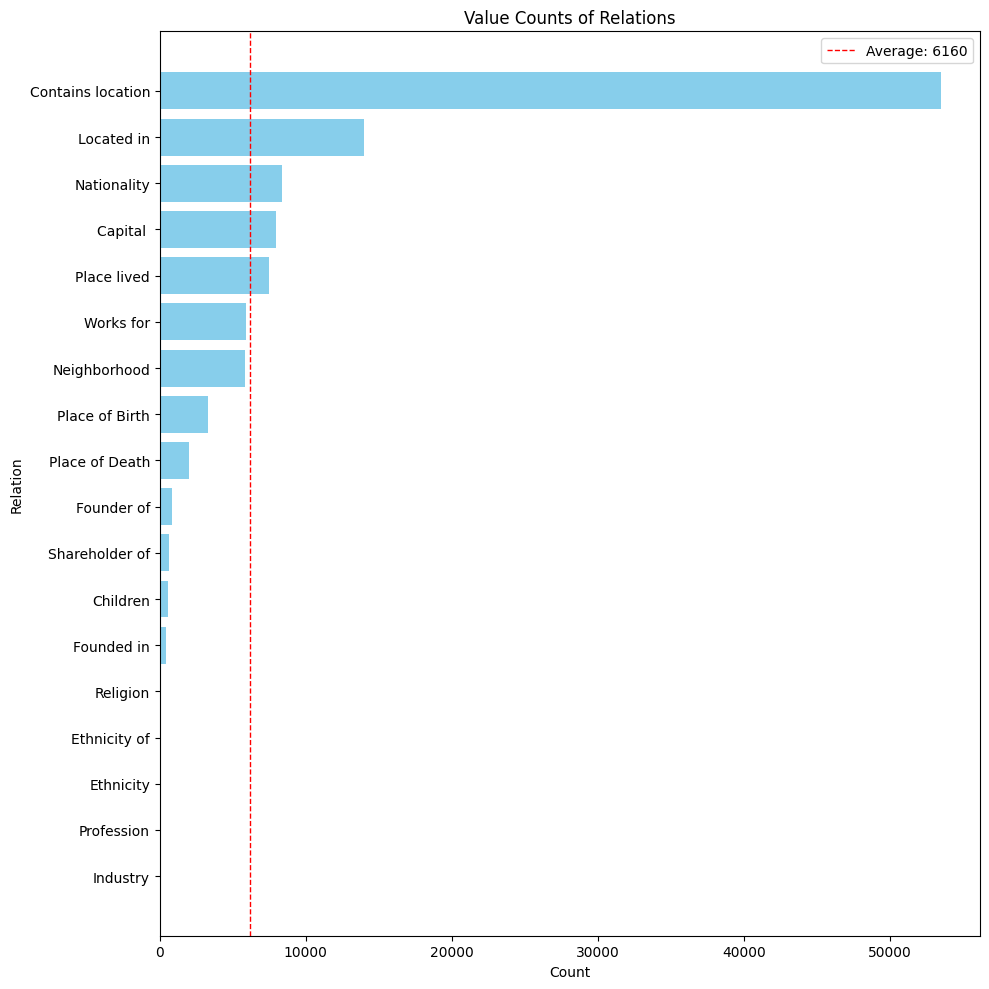

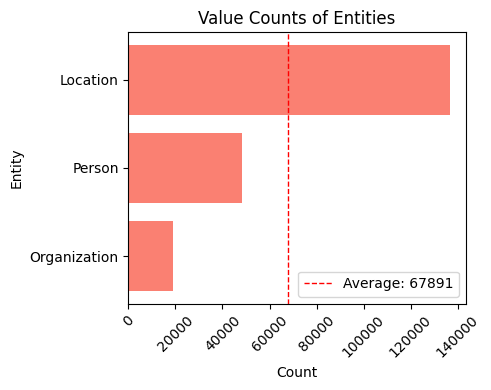

In [9]:
# Plotting the value counts of relations horizontally
relation_df = relation_df.sort_values(by='Count', ascending=True)
average_relation_count = relation_df['Count'].mean()

plt.figure(figsize=(10, 10))
plt.barh(relation_df['Relation'], relation_df['Count'], color='skyblue')
plt.axvline(average_relation_count, color='red', linestyle='--', linewidth=1, label=f'Average: {average_relation_count:.0f}')
plt.xlabel('Count')
plt.ylabel('Relation')
plt.title('Value Counts of Relations')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting the value counts of entities
entity_df = entity_df.sort_values(by='Count', ascending=True)
average_entity_count = entity_df['Count'].mean()

plt.figure(figsize=(5, 4))
plt.barh(entity_df['Entity'], entity_df['Count'], color='salmon')
plt.axvline(average_entity_count, color='red', linestyle='--', linewidth=1, label=f'Average: {average_entity_count:.0f}')
plt.xlabel('Count')
plt.ylabel('Entity')
plt.title('Value Counts of Entities')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plotting distributions of splits

In [10]:
test = pd.read_json("/Users/peetz/Documents/GitHub/LLM_Thesis/data/data_finalized/NYT/test.json", orient="records", lines=False)
dev = pd.read_json("/Users/peetz/Documents/GitHub/LLM_Thesis/data/data_finalized/NYT/dev.json", orient="records", lines=False)
train = pd.read_json("/Users/peetz/Documents/GitHub/LLM_Thesis/data/data_finalized/NYT/train.json", orient="records", lines=False)
distant = pd.read_json("/Users/peetz/Documents/GitHub/LLM_Thesis/data/data_finalized/NYT/train_distant.json", orient="records", lines=False)

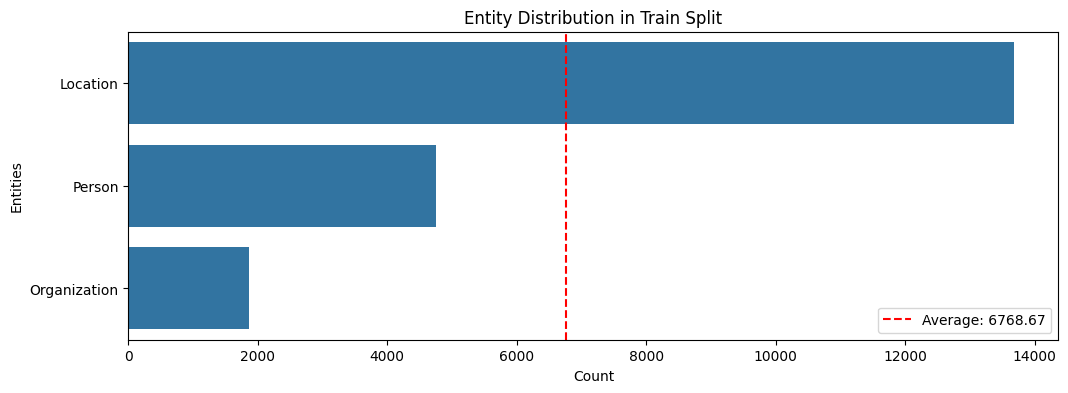

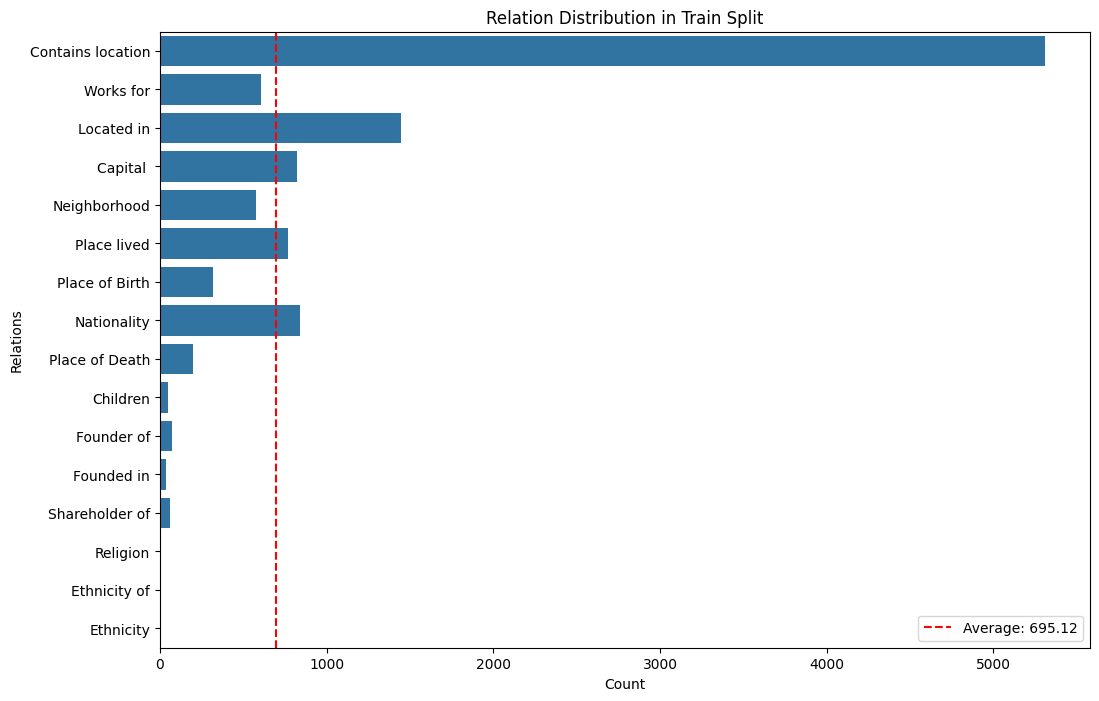

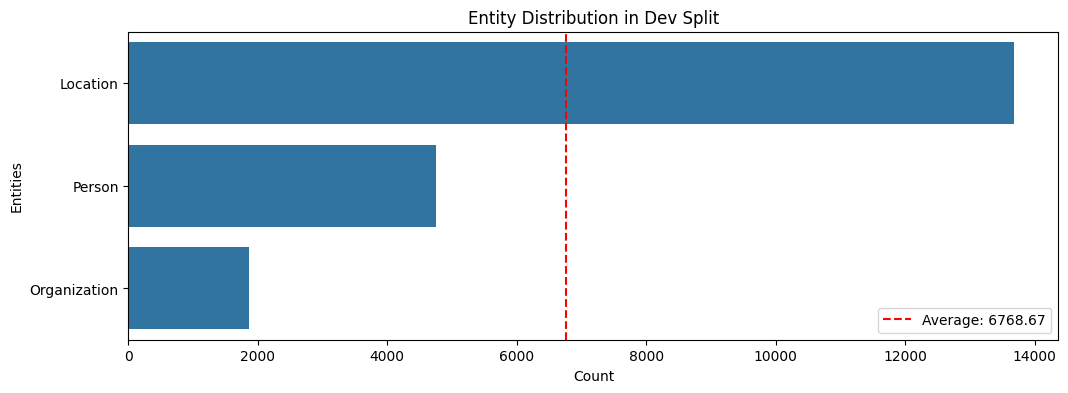

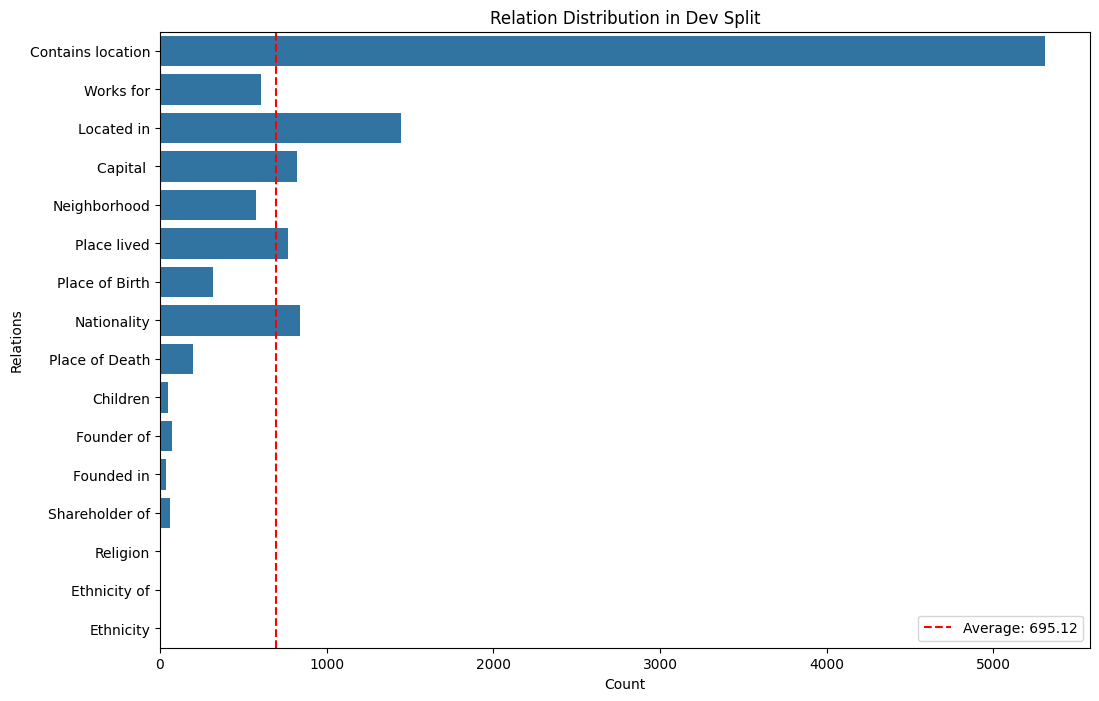

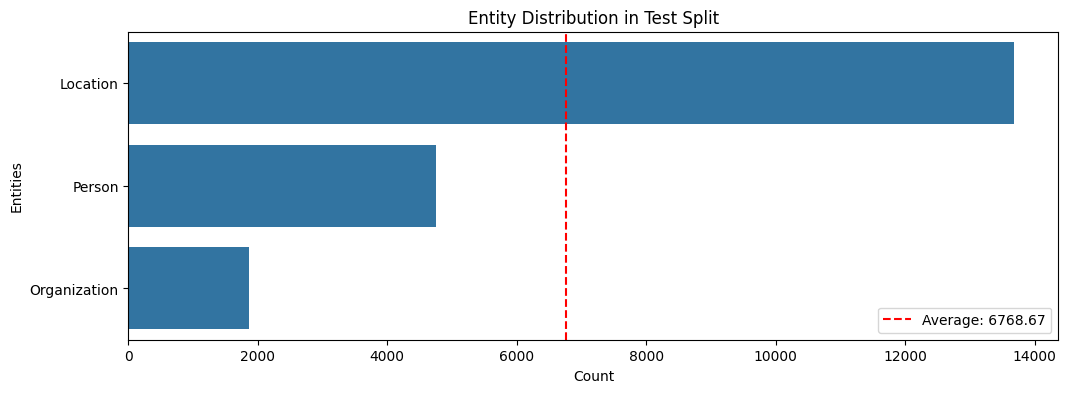

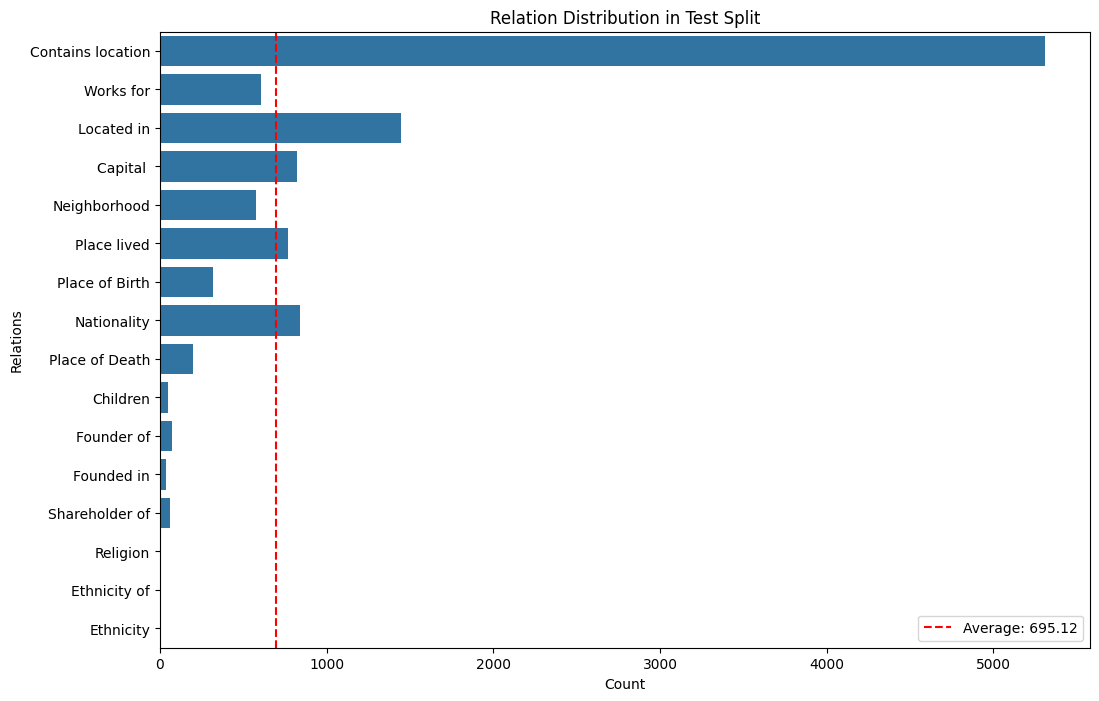

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pathlib import Path
import os

# # Adjusted split function
# def get_data_split(df, dataset_name=None, output_dir=None, gen_new_distant=True, output=True):
#     if "dataset" not in df.columns and dataset_name is None:
#         raise ValueError("DataFrame must contain a 'dataset' column or a 'dataset_name' must be specified.")

#     if dataset_name:  
#         if dataset_name == "DocRED":
#             print(f"Processing {dataset_name} data...")
#             distant = df[df["original_file_path"].str.contains("distant")]
#             un_distant = df[~df["original_file_path"].str.contains("distant")]
#             test = un_distant[un_distant["original_file_path"].str.contains("test")]
#             remainder = un_distant[~un_distant["original_file_path"].str.contains("test")]
#             if not gen_new_distant:
#                 print("Combining distant and non-distant data...")
#                 remainder = pd.concat([distant, remainder])
#             train, dev = train_test_split(remainder, test_size=0.5, random_state=42)
#         elif dataset_name == "NYT":
#             print(f"Processing {dataset_name} data...");
#             if gen_new_distant:
#                 df, distant = train_test_split(df, train_size=0.1, random_state=42)
#             test = df[df["original_file_path"].str.contains("test")]
#             dev = df[df["original_file_path"].str.contains("valid")]
#             train = df[df["original_file_path"].str.contains("train")]
#         elif dataset_name == "sciERC":
#             print(f"Processing {dataset_name} data...");
#             if gen_new_distant:
#                 df, distant = train_test_split(df, train_size=0.1, random_state=42)
#             test = df[df["original_file_path"].str.contains("test")]
#             dev = df[df["original_file_path"].str.contains("dev")]
#             train = df[df["original_file_path"].str.contains("train")]
#         elif dataset_name == "CoNLL04":
#             print(f"Processing {dataset_name} data...");
#             if gen_new_distant:
#                 df, distant = train_test_split(df, train_size=0.1, random_state=42)
#             dev, test = train_test_split(df, test_size=0.66, random_state=42)
#             train, dev = train_test_split(dev, test_size=0.5, random_state=42)
#         elif dataset_name == "CrossRE":
#             print(f"Processing {dataset_name} data...");
#             if gen_new_distant:
#                 gold1 = df[df["original_file_path"].str.contains("NLP")]
#                 gold2 = df[df["original_file_path"].str.contains("linguist")]
#                 train = pd.concat([gold1, gold2])
#                 remainder = df[~df.index.isin(train.index)]
#                 remainder, distant = train_test_split(remainder, test_size=0.8, random_state=42)
#                 dev, test = train_test_split(remainder, test_size=0.5, random_state=42)
#         elif dataset_name == "ALL":
#             print("Combining all datasets...");
#             distant_dfs, test_dfs, dev_dfs, train_dfs = [], [], [], []

#             for dataset in ["DocRED", "NYT", "sciERC", "CoNLL04", "CrossRE"]:
#                 current_df = df[df["org_dataset"] == dataset]
#                 train, dev, test, distant = get_data_split(current_df, dataset_name=dataset, gen_new_distant=gen_new_distant)
#                 distant_dfs.append(distant)
#                 test_dfs.append(test)
#                 dev_dfs.append(dev)
#                 train_dfs.append(train)

#             distant = pd.concat(distant_dfs)
#             test = pd.concat(test_dfs)
#             dev = pd.concat(dev_dfs)
#             train = pd.concat(train_dfs)
#         else:
#             raise ValueError("Unsupported dataset_name provided.")

#     if output_dir is None:
#         output_dir = str(Path(root_dir, "processed_data", dataset_name))
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
#     if output:
#         train.to_json(Path(output_dir, "train.json"), orient="records", lines=False)
#         dev.to_json(Path(output_dir, "dev.json"), orient="records", lines=False)
#         test.to_json(Path(output_dir, "test.json"), orient="records", lines=False)
#         if gen_new_distant:
#             distant.to_json(Path(output_dir, "train_distant.json"), orient="records", lines=False)
#     if gen_new_distant: 
#         return train, dev, test, distant
#     else: 
#         return train, dev, test, None

# Function to extract entities and relations from the vertexSet and labels columns
def extract_entities_relations(split):
    entities = []
    relations = []
    for index, row in split.iterrows():
        entities.extend([entity['type'] for entity_set in row['vertexSet'] for entity in entity_set])
        relations.extend([label['r'] for label in row['labels']])
    return pd.Series(entities), pd.Series(relations)

# Function to calculate average counts
def calculate_average_counts(series):
    value_counts = series.value_counts()
    return value_counts.mean()

# Plotting function
def plot_distribution(data, avg_count, title, xlabel, ylabel, is_relation=False):
    plt.figure(figsize=(12, 8) if is_relation else (12, 4))
    sns.countplot(y=data)
    plt.axvline(x=avg_count, color='r', linestyle='--', label=f'Average: {avg_count:.2f}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


# train, dev, test, _ = get_data_split(df, dataset_name='NYT', output=False)

# Extract entities and relations for each split
train_entities, train_relations = extract_entities_relations(train)
dev_entities, dev_relations = extract_entities_relations(dev)
test_entities, test_relations = extract_entities_relations(test)

# Calculate average counts
avg_train_entities = calculate_average_counts(train_entities)
avg_train_relations = calculate_average_counts(train_relations)
avg_dev_entities = calculate_average_counts(dev_entities)
avg_dev_relations = calculate_average_counts(dev_relations)
avg_test_entities = calculate_average_counts(test_entities)
avg_test_relations = calculate_average_counts(test_relations)

# Plotting the distributions
if not train_entities.empty:
    plot_distribution(train_entities, avg_train_entities, 'Entity Distribution in Train Split', 'Count', 'Entities')
if not train_relations.empty:
    plot_distribution(train_relations, avg_train_relations, 'Relation Distribution in Train Split', 'Count', 'Relations', is_relation=True)

if not dev_entities.empty:
    plot_distribution(dev_entities, avg_dev_entities, 'Entity Distribution in Dev Split', 'Count', 'Entities')
if not dev_relations.empty:
    plot_distribution(dev_relations, avg_dev_relations, 'Relation Distribution in Dev Split', 'Count', 'Relations', is_relation=True)

if not test_entities.empty:
    plot_distribution(test_entities, avg_test_entities, 'Entity Distribution in Test Split', 'Count', 'Entities')
if not test_relations.empty:
    plot_distribution(test_relations, avg_test_relations, 'Relation Distribution in Test Split', 'Count', 'Relations', is_relation=True)


## Plotting sentence lengths

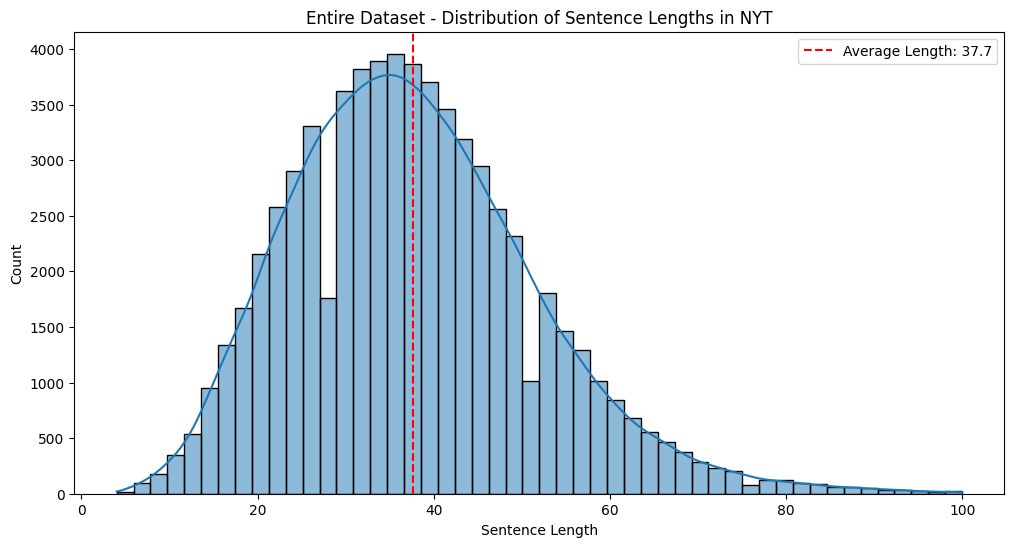

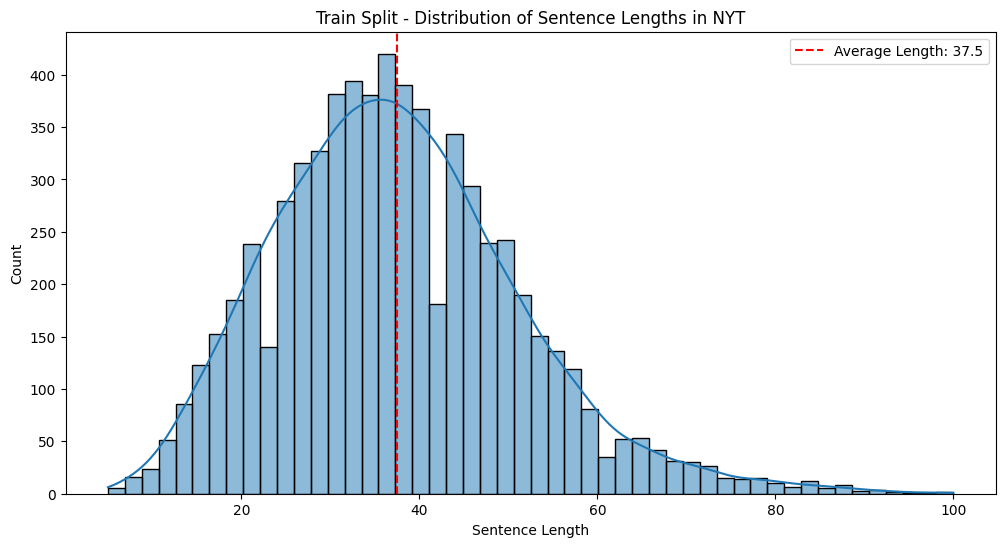

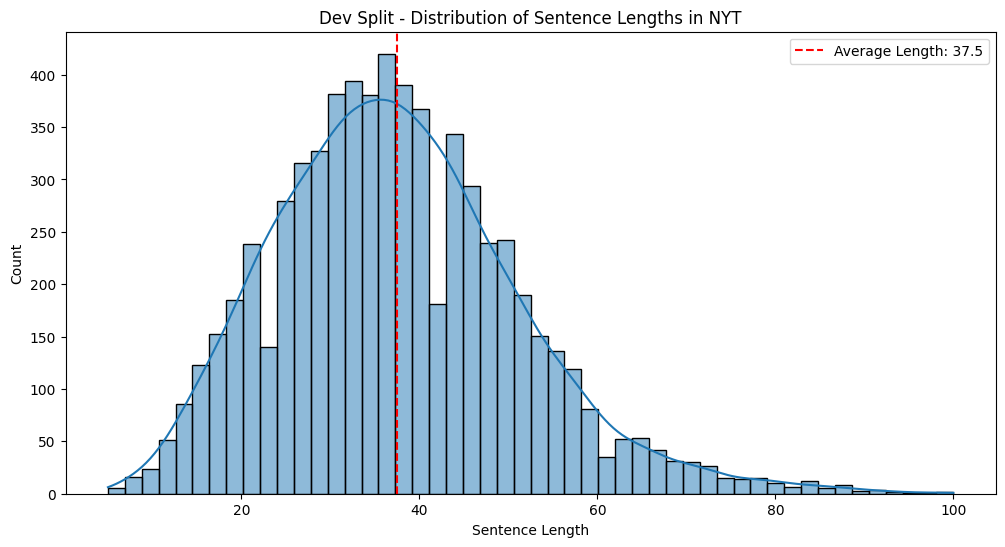

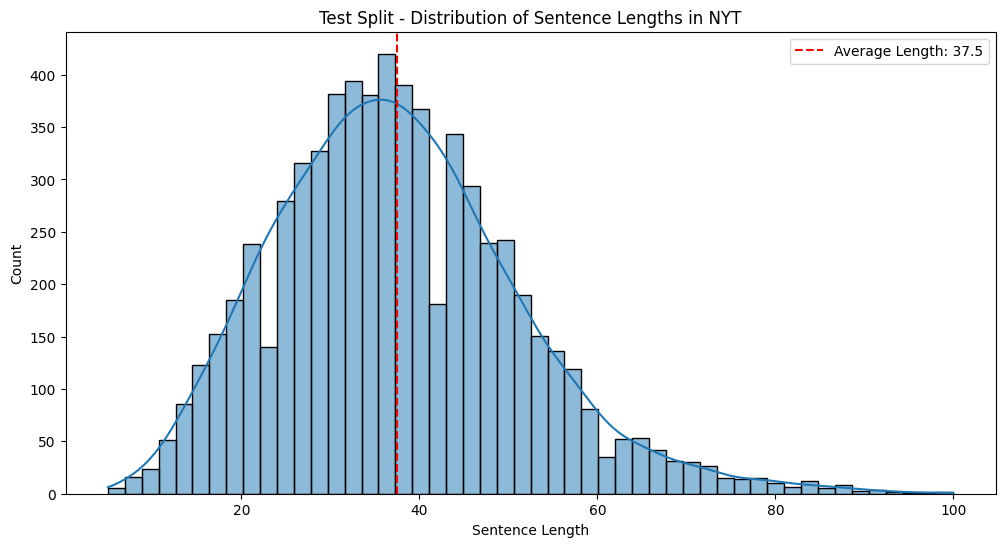

In [12]:
# Function to calculate and plot sentence length distribution
def plot_sentence_length_distribution(dataset_name, dataset_df, title_prefix):
    sent_length = []
    for sent in dataset_df['sents']:
        for s in sent:
            sent_length.append(len(s))
    avg_length = sum(sent_length) / len(sent_length)
    plt.figure(figsize=(12, 6))
    sns.histplot(sent_length, bins=50, kde=True)
    plt.axvline(x=avg_length, color='r', linestyle='--', label=f'Average Length: {avg_length:.1f}')
    plt.xlabel('Sentence Length')
    plt.ylabel('Count')
    plt.title(f'{title_prefix} - Distribution of Sentence Lengths in {dataset_name}')
    plt.legend()
    plt.show()

# Plot for the entire dataset
for dataset in df['org_dataset'].unique():
    dataset_df = df[df['org_dataset'] == dataset]
    plot_sentence_length_distribution(dataset, dataset_df, 'Entire Dataset')

# Plot for the individual splits
for split_name, split_df in [('Train Split', train), ('Dev Split', dev), ('Test Split', test)]:
    for dataset in split_df['org_dataset'].unique():
        dataset_df = split_df[split_df['org_dataset'] == dataset]
        plot_sentence_length_distribution(dataset, dataset_df, split_name)